In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow_probability import distributions as tfd
from collections import defaultdict
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append('/content/model')
from model import gp_vae

In [ ]:
DATA_DIR="/content"
SEQ_LENGTH = 60
SKIP_PROP = 12
"""
  Using non-overlapping time series can mean very little data to train/test. 
  Instead use overlapping subsets where skip length given by SEQ_LENGTH//SKIP_PROP.
"""

!mkdir -p ${DATA_DIR}

tickerList = ["AMZN", "GOOG", "AAPL", 
              "MMM", "ABT", "EBAY", 
              "GE", "K", "MAR", "MS", 
              "RTX", "ROK", "BA", 
              "KO", "F", "GLW",
              "MAR", "MSI", "QCOM", "SBUX", 
              "TXN", "TSN", "TSN",
              "VIAC", "CVX", "HSY", "MRK", 
              "PEP", "PG", "HON", 
              "SLB", "GIS", "JNJ", 
              "HPQ", "DIS", "WMT", "T", "VZ", "MSFT"]

start =datetime(2006, 1, 1)
end = datetime(2019, 1, 1)

#data = pdr.DataReader(tickerList, start=start, end=end, data_source="yahoo")
#data.to_pickle(DATA_DIR+"/raw_data.pkl")

data = pd.read_pickle(DATA_DIR+"/raw_data.pkl")
data = data["Adj Close"]#.apply(np.log1p)
data.dropna(axis=1, inplace=True)
#data = data[data.columns[:2]]
#data["BBPL"] = data.values

num_stocks = data.shape[1]

#scaler = MinMaxScaler()
#train_data = scaler.fit_transform(data[:int(0.8*len(data))])
#val_data = scaler.transform(data[int(0.8*len(data)):])
train_data = data[:int(0.8*len(data))]
val_data = data[int(0.8*len(data)):]

dsplits_train = np.array([train_data[i-SEQ_LENGTH:i] for i in range(SEQ_LENGTH, len(train_data), SEQ_LENGTH//SKIP_PROP)])
dsplits_val = np.array([val_data[i-SEQ_LENGTH:i] for i in range(SEQ_LENGTH, len(val_data), SEQ_LENGTH//SKIP_PROP)])
# Centre each time series around 0 by mean subtraction
dsplits_train = np.array([d-np.mean(d, axis=0) for d in dsplits_train])
dsplits_val = np.array([d-np.mean(d, axis=0) for d in dsplits_val])

mask = []
masked_data = []
clean_data = []

DROP_PCT = 0.5
"""
Create some train/test data by manually creating drop masks and dropping
These are not used during training, we rely on the model to dynamically drop values
As a result this is not strictly necessary
These data can be used instead of dynamic augmentation by not enabling augmentation at train time
"""
dtrain = []
mtrain = []
ctrain = []

for d in dsplits_train:
  # Static dropout for entire data-batch
  #DROP_PCT = np.random.uniform(0.3, 0.8) # Random drop % between 0 and 1
  #m = np.random.choice([0, 1], size=d.shape, p=[DROP_PCT, 1-DROP_PCT])

  # Dynamic dropout for each time series in each data-batch
  m = []
  for _ in range(d.shape[0]): # Different drop % for each stock-series in each sample
    DROP_PCT = np.random.uniform(0.4, 0.8)
    m.append(np.random.choice([0, 1], size=d.shape[1], p=[DROP_PCT, 1-DROP_PCT]))
  m = np.vstack(m)

  # Apply dropout and save dropped out data, mask and clean data
  mtrain.append(m)
  dtrain.append(np.array(np.multiply(d, m)))
  ctrain.append(d)

mtrain = np.array(mtrain, dtype=np.float32) # Removal mask
dtrain = np.array(dtrain, dtype=np.float32) # Data with values removed
ctrain = np.array(ctrain, dtype=np.float32) # Data without values removed

#dtrain = np.array([d-np.mean(d, axis=0) for d in dtrain])
#ctrain = np.array([d-np.mean(d, axis=0) for d in ctrain])



dval = []
mval = []
cval = []

for d in dsplits_train:
  # Static dropout for entire data-batch
  #DROP_PCT = np.random.uniform(0.3, 0.8) # Random drop % between 0 and 1
  #m = np.random.choice([0, 1], size=d.shape, p=[DROP_PCT, 1-DROP_PCT])

  # Dynamic dropout for each time series in each data-batch
  m = []
  for _ in range(d.shape[0]): # Different drop % for each stock-series in each sample
    DROP_PCT = np.random.uniform(0.4, 0.8)
    m.append(np.random.choice([0, 1], size=d.shape[1], p=[DROP_PCT, 1-DROP_PCT]))
  m = np.vstack(m)

  # Apply dropout and save dropped out data, mask and clean data
  mval.append(m)
  dval.append(np.array(np.multiply(d, m)))
  cval.append(d)

mval = np.array(mval, dtype=np.float32) # Removal mask
dval = np.array(dval, dtype=np.float32) # Data with values removed
cval = np.array(cval, dtype=np.float32) # Data without values removed

#dval = np.array([d-np.mean(d, axis=0) for d in dval])
#cval = np.array([d-np.mean(d, axis=0) for d in cval])


In [ ]:
"""
  Create params here for clarity
"""
flags = {}

flags['latent_dim'] = num_stocks*10 # Dimensionality of the latent space
flags['encoder_sizes'] =  [128, 128] # Layer sizes of the encoder
flags['decoder_sizes'] =  [256, 256] # Layer sizes of the decoder
flags['window_size'] =  SEQ_LENGTH//2 # Window size for the inference CNN
flags['sigma'] = 1.005 # Sigma value for the GP prior
flags['length_scale'] =  5.0 # Length scale value for the GP prior
flags['beta'] =  1.0 # Factor to weigh the KL term (similar to beta-VAE)
flags['num_epochs'] = 500 # Number of training epochs

flags['learning_rate'] = 1e-3 # Learning rate for training 
flags['gradient_clip'] = 1e4 # Maximum global gradient norm for the gradient clipping during training
flags['print_interval'] = 100 # Interval for printing the loss and saving the model during training
flags['exp_name'] =  "test" # Name of the experiment
flags['basedir'] = "/content" # Directory in which the models should be stored
flags['data_dir'] =  "" # Directory from where the data should be read in
flags['seed'] =  7  # Seed for the random number generator
flags['batch_size'] =  128 # 'Batch size for training
flags['paper_version'] =  False # Use paper's version of decoder with variance=1 time series or train model to learn covariance

flags['M'] =  1 # Number of samples for ELBO estimation
flags['K'] = 1 # Number of importance sampling weights

flags['kernel'] = 'cauchy' # ['rbf', 'matern', 'cauchy'], Kernel to be used for the GP prior
flags['kernel_scales'] = 1 # Number of different length scales sigma for the GP prior

"""
  Choosing kernel scales allows exploration of several length scales ie. for kernel scale N and length scale L
  we explore L/2^0, L/2^1, ..., L/2^N
"""

flags['data_dim'] = num_stocks
flags['time_length'] = SEQ_LENGTH
FLAGS = flags

In [ ]:
model = gp_vae.GP_VAE(flags)


In [ ]:
tf_x_train_miss = tf.data.Dataset.from_tensor_slices((dtrain, mtrain, ctrain)).shuffle(len(dtrain)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.data.Dataset.from_tensor_slices((dval, mval)).batch(FLAGS['batch_size']).repeat()
tf_x_val_miss = tf.compat.v1.data.make_one_shot_iterator(tf_x_val_miss)

print("GPU support: ", tf.config.list_physical_devices('GPU'))
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=FLAGS["learning_rate"])

num_steps = FLAGS["num_epochs"] * len(dtrain) // FLAGS["batch_size"] # Number of total training steps

losses_train = []
losses_val = []

# Set model to training mode and enable mini-batch augmentation
model.train(augment_at_train_time=True)
# Change % of points dropped, ie. drop between 0-50% of all data (default is [0.3, 0.8])
model.drop_pct_range = [0.0, 0.5]

t0 = time.time()

for i, (x_seq, m_seq, c_seq) in enumerate(tf_x_train_miss.take(num_steps)):
  # Train on missing data
  with tf.GradientTape() as tape:
      tape.watch(trainable_vars)
      loss = model.compute_loss(c_seq) # If using a predefined training set replace c_seq with x_seq
      losses_train.append(loss.numpy())
  grads = tape.gradient(loss, trainable_vars)
  grads = [np.nan_to_num(grad) for grad in grads]
  grads, global_norm = tf.clip_by_global_norm(grads, flags["gradient_clip"])
  optimizer.apply_gradients(zip(grads, trainable_vars), global_step=tf.compat.v1.train.get_or_create_global_step())

  # Print results periodically
  if i % FLAGS['print_interval'] == 0:
      print("================================================")
      print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, global_norm))
      print("Time Elapsed = {:2f}".format(time.time() - t0))
      # If using a pre-defined training set uncomment these
      #loss, nll, kl = model.compute_loss(x_seq, m_mask=m_seq, return_parts=True)
      #print("Train loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(loss, nll, kl))

      # Validation loss
      x_val_batch, m_val_batch = tf_x_val_miss.get_next()
      val_loss, val_nll, val_kl = model.compute_loss(x_val_batch, m_mask=m_val_batch, return_parts=True)
      losses_val.append(val_loss.numpy())
      print("Validation loss = {:.3f} | NLL = {:.3f} | KL = {:.3f}".format(val_loss, val_nll, val_kl))

print("Complete")

GPU support:  []
Learning rate: 0.001 | Global gradient norm: 430347.22
Time Elapsed = 7.769112
Validation loss = 2089559.250 | NLL = 1335.014 | KL = 2088224.250
Learning rate: 0.001 | Global gradient norm: 5611.41
Time Elapsed = 641.743838
Validation loss = 48961.703 | NLL = 1508.414 | KL = 47453.289
Learning rate: 0.001 | Global gradient norm: 8394.99
Time Elapsed = 1266.477603
Validation loss = 55420.961 | NLL = 1995.358 | KL = 53425.602
Learning rate: 0.001 | Global gradient norm: 7427.13
Time Elapsed = 1890.242214
Validation loss = 325032.938 | NLL = 199096.422 | KL = 125936.484
Learning rate: 0.001 | Global gradient norm: 5766.50
Time Elapsed = 2516.471614
Validation loss = 55162.547 | NLL = 3400.041 | KL = 51762.504


In [ ]:
model.eval()
res = model(np.multiply(cval, mval), with_var=True)
t, std = res[0].numpy(), res[1].numpy()
d = cval
c = np.multiply(cval, mval)
samples = model.sample(np.multiply(cval, mval), num_samples=2)


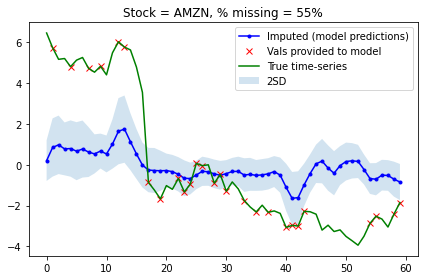

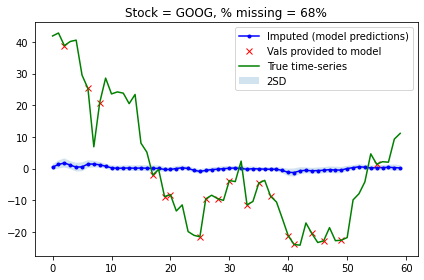

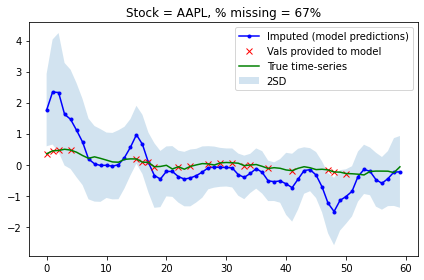

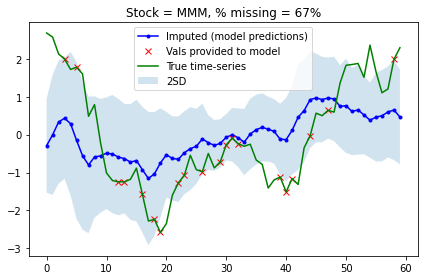

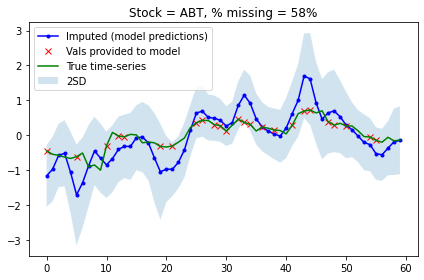

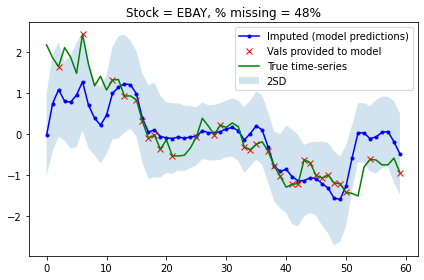

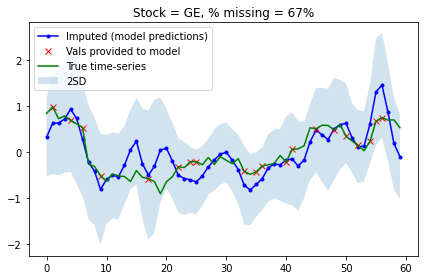

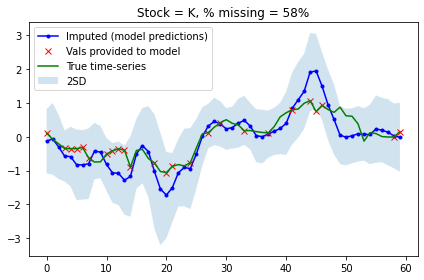

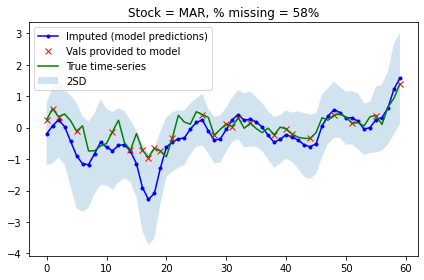

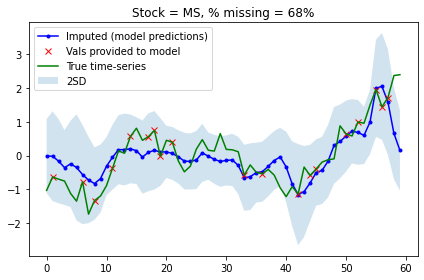

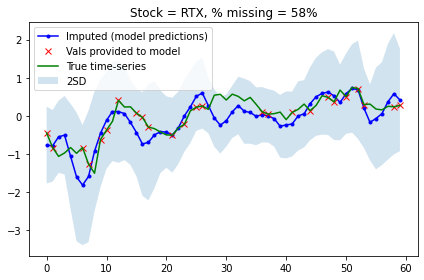

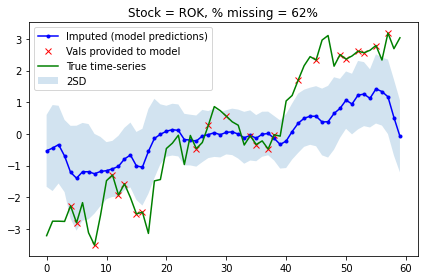

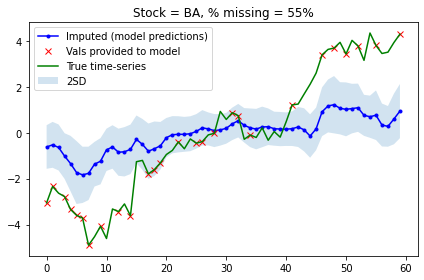

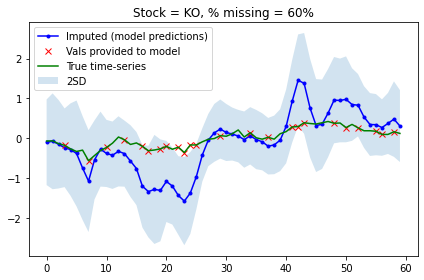

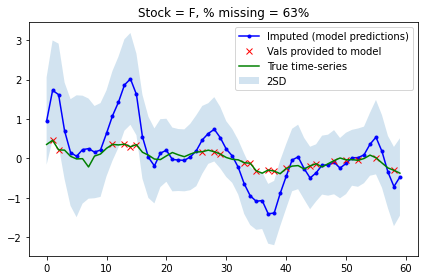

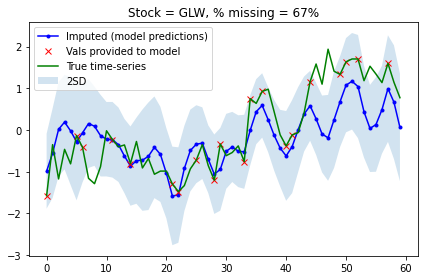

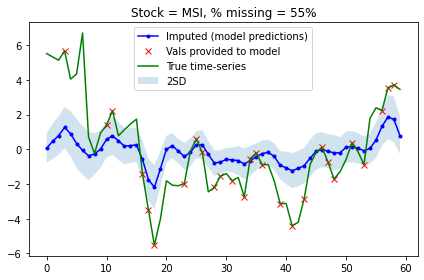

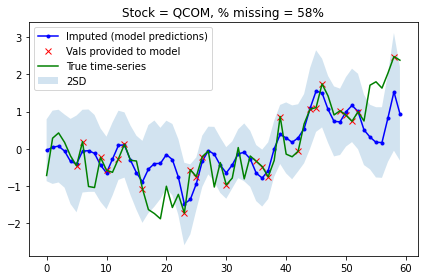

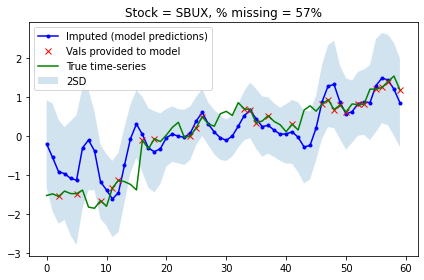

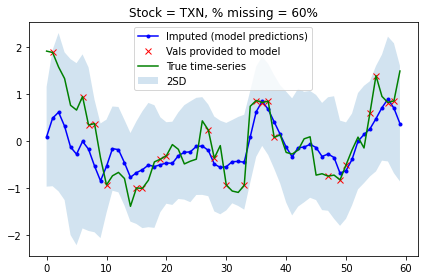

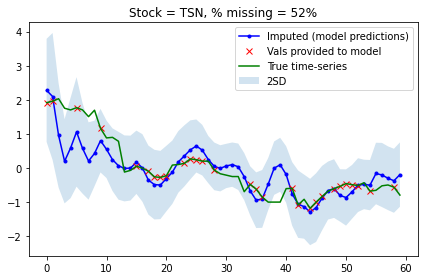

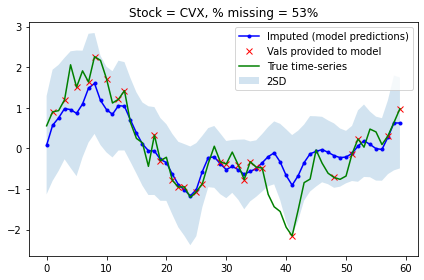

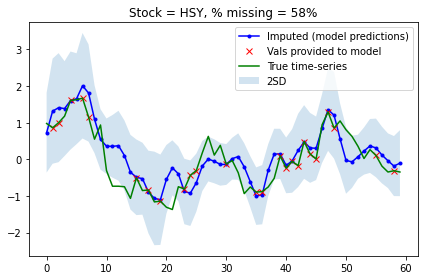

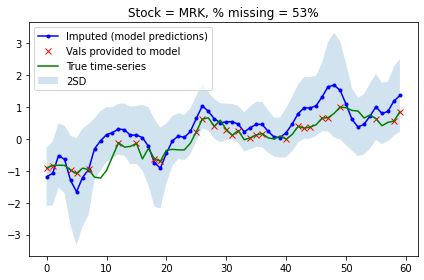

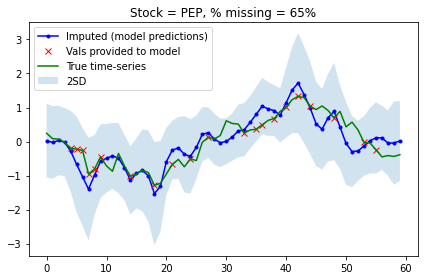

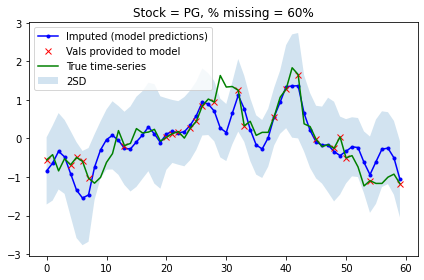

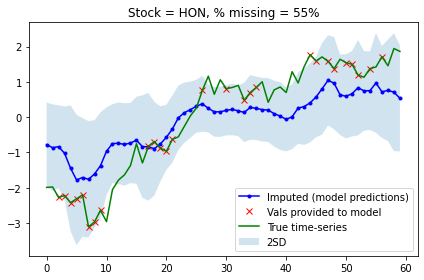

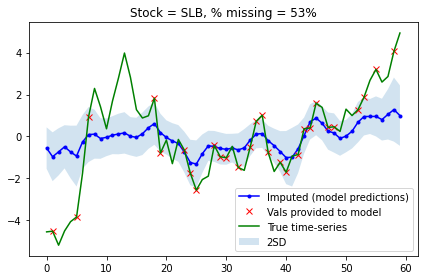

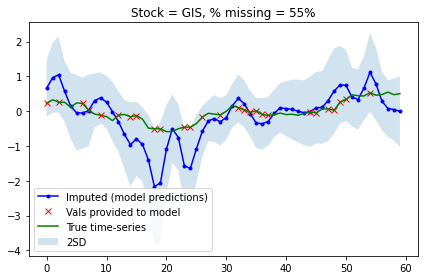

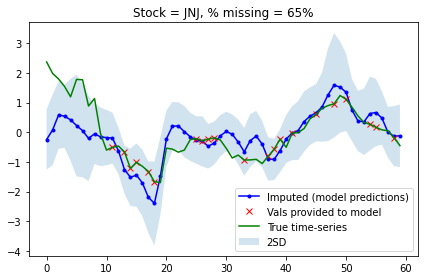

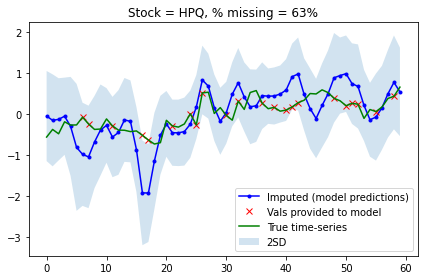

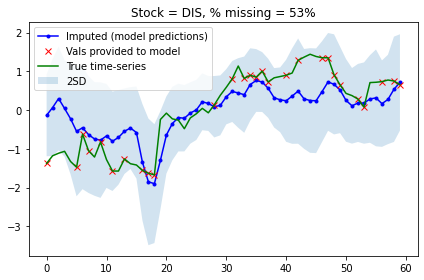

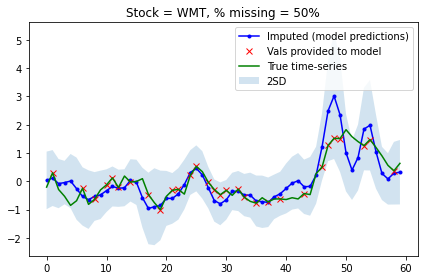

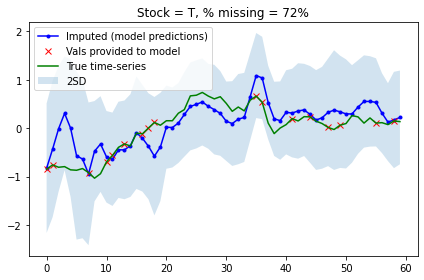

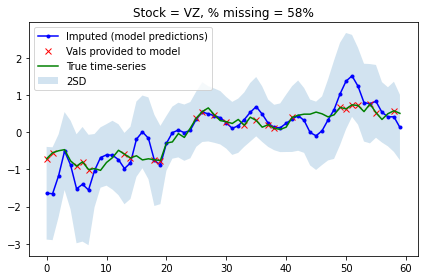

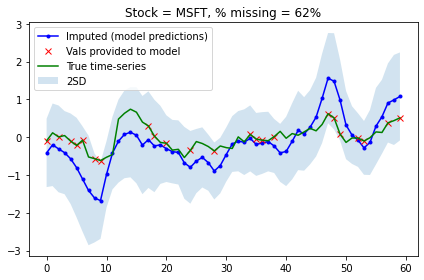

In [ ]:
s_num = 1

for xnum, stock in enumerate(data.columns):
  imputed = t[s_num, :, xnum]
  imputed_std = np.sqrt(std[s_num, :, xnum])
  true = d[s_num, :, xnum]
  missing_vals = c[s_num, :, xnum]
  mask = mval[s_num, :, xnum]
  samps = tf.transpose(samples[:, s_num, :, xnum])
  rep_imputed = [x if y==1 else i for y,x,i in zip(mask, true, imputed)]
  #imputed = rep_imputed

  #plt.plot(samps, ".-y", label="Samples", alpha=0.8)
  plt.plot(imputed, ".-b", label="Imputed (model predictions)")
  #plt.plot(rep_imputed, ".-b", label="Imputed (model predictions)")
  plt.fill_between(np.arange(0, len(imputed)), imputed+imputed_std*2, imputed-imputed_std*2, alpha=0.2, label="2SD")
  plt.plot([float('nan') if y==0 else x for x,y in zip(true, mask)], "xr", label="Vals provided to model")
  #plt.plot([m if x==0 else float('nan') for x, m in zip(true, missing_vals)], "xg")
  plt.plot(true, "-g", label="True time-series")
  plt.title("Stock = " + str(stock) + ", % missing = " + str(round(100-100*np.sum(mask)/len(mask))) + "%")
  plt.legend()
  plt.tight_layout()
  plt.show()